## Comparison of the Russian Five-Act Comedies in Verse With Other Traditions

In this analysis, we will compare the Russian five-act comedy in verse with the French five-act comedy in verse as well as Shakespeare and Goldoni's five-act comedies in verse. 

We will compare the mean values of each feature. For the French tradition, we will rely on the periodization that we introduced in our previous analyses. However, we will need to split Period Two into two to be able to compare the French tradition with the contemporaneous Russian tradition:
- Period One: from 1629 to 1695
- Period Two First Part: from 1696 to 1774
- Period Two Second Part: from 1775 to 1795.
- Period Three: from 1796 to 1849.

For the Russian tradition, we were unable to distinguish periods that would have significanltly different distribution of the examined features. However, for comparison with the French tradition, we will assume "tentative" periods:
- Tentative Period One: 1775 to 1795
- Tentative Period Two: 1796 to 1849.

For Shakespeare, we will use the mean values of the features for his entire corpus of the five-act comedies in verse. For Goldoni, we will use the mean values of the features for the stratified 30% random sample of his comedies. 

The sampling is described in this notebook: https://github.com/innawendell/European_Comedy/blob/master/Analyses/Goldoni_Sample.ipynb. 

We will compare Goldoni with the contemporaneous French comedies and Russian comedies of the tentative Period One and Two since there were no Russian comedies written during the time when Goldoni was active.

1. The comparison will be based on the following features:
    - The number of dramatic characters;
    - The mobility coefficient;
    - The standard range of the number of speaking characters (sigma);
    - The percentage of non-dialogues;
    - The percentage of polylogues;
    - The percentage of monologues;
    - The coefficient of unused dramatic characters;
    - The percentage of discontinuous scenes;
    - The speech distribution.
    
2. We will produce open-form scores for each tradition by decade. These open-form scores will allow us to compare different traditions in terms of being more or less experimental.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from os import listdir
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import normalize
import json
import re

In [2]:
# update the boundaries as we determined based on our hypothesis testing
def determine_period(row):
    if row <= 1695:
        period = '1'
    elif row >= 1696 and row <= 1774:
        period = '2_a'
    elif row >= 1775 and row <= 1795:
        period = '2_b'
    else:
        period = '3'
    
    return period

In [3]:
def make_list(row):
    speech_dist = []
    for value in row[1:-1].split('\n '):
        speech_dist.append([int(num) for num in re.findall('[0-9]+', value)])
        
    return speech_dist

In [4]:
def speech_distribution_by_period(period_df):
    all_distributions = []
    for row in period_df['speech_distribution']:
        speech_dist_df = pd.DataFrame(row).T
        # rename columns to make sure they start with 1 and not 0
        speech_dist_df.columns = speech_dist_df.iloc[0, :]
        # no need to include the variants as a row - they will be column names
        only_counts_df = pd.DataFrame(speech_dist_df.iloc[1, :])
        only_counts_df.columns = ['raw_numbers']
        only_counts_df['percentage'] = only_counts_df['raw_numbers'] / only_counts_df.sum().values[0]
        all_distributions.append(round(only_counts_df['percentage'], 4))
        
    period_df_dist = pd.concat(all_distributions, axis=1).fillna(0)
    # take the mean for each period
    mean_per_type = pd.DataFrame(period_df_dist.mean(axis=1)).T 
    mean_per_type = (mean_per_type * 100).round(2)
    mean_per_type.index = ['percentage_of_scenes']
    mean_per_type.index.name = 'number_of_speakers'
    
    return mean_per_type

In [5]:
def sigma_iarkho(variants, weights):
    """
    The function allows calculating standard range following iarkho's procedure.
    Parameters:
        variants - a list with distinct variants in the ascending order, e.g. [1, 2, 3, 4, 5]
        weights - a list of weights corresponding to these variants, e.g. [20, 32, 18, 9, 1]
    Returns:
        sigma - standard range per iarkho
    """
    weighted_mean_variants = np.average(variants, weights=weights)
    differences_squared = [(variant - weighted_mean_variants)**2 for variant in variants]
    weighted_mean_difference = np.average(differences_squared, weights=weights)
    sigma = weighted_mean_difference**0.5

    return sigma

In [6]:
def coefficient_unused_dramatic_characters(data):
    total_present = 0
    total_non_speakers = 0
    for act in data['play_summary'].keys():
        for scene in data['play_summary'][act].keys():
            # identify the raw number of non-speaking dramatic characters
            num_non_speakers = len([item for item in data['play_summary'][act][scene].items() 
                                if (item[1] == 0  or item[1] == 'non_speaking') and item[0] not in ['num_utterances',
                                                                   'num_speakers',
                                                                   'perc_non_speakers']])
            total_non_speakers += num_non_speakers
            # calculate the total number of dramatic characters
            total_present += (data['play_summary'][act][scene]['num_speakers'] + num_non_speakers)
    coefficient_unused = (total_non_speakers / total_present ) * 100        
    
    return coefficient_unused

In [7]:
def get_data(input_directory):
    all_files = [f for f in listdir(input_directory) if f.count('.json') > 0]
    dfs = []
    for file in all_files:
        with open(input_directory + '/' + file) as json_file:
            data = json.load(json_file)
            not_used = coefficient_unused_dramatic_characters(data)
            df = pd.DataFrame([not_used], columns=['coefficient_unused'], index=[file.replace('.json','')])
            dfs.append(df)
            
    features_df = pd.concat(dfs, axis=0, sort=False).round(2)
    
    return features_df

In [8]:
def plot_speech_distribution(speech_dist_df, title):
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=14)
    sns.barplot(x=speech_dist_df.columns.tolist(), 
                y=speech_dist_df.values.tolist()[0])
    plt.xlabel('Number of Speakers', fontsize=12)
    plt.ylabel('Percentage of Scenes', fontsize=12)

    plt.show()

In [9]:
def interval_data(data_df, feature, other_tradition_df=None):
    if other_tradition_df is not None:
        overall_mean = round(other_tradition_df[feature].mean(), 2)
        overall_std = round(other_tradition_df[feature].std(), 2)
    else:
        overall_mean = round(data_df[feature].mean(), 2)
        overall_std = round(data_df[feature].std(), 2)
    
    statistics = ['mean'] 
    all_data = pd.DataFrame(data_df.groupby(['decades'])[feature].mean())
    all_data.columns= ['mean']
    all_data['z_score'] = (all_data['mean'] - overall_mean) / overall_std
    
    return  all_data

In [10]:
def scores_calculation(df, with_z_score=True, other_tradition_df=None):
    if with_z_score:
        column = 'z_score'
        sigma_col = column
    else:
        column = ['mean']
        sigma_col = 'sigma_iarkho'       
    summary = pd.DataFrame(interval_data(df, 'num_present_characters', other_tradition_df)[column])
    summary.columns = ['num_present_characters']
    # make sure the order of the playwrights is the same
    
    ind = summary.index
    summary['mobility_coefficient'] = interval_data(df, 'mobility_coefficient', 
                                                   other_tradition_df).loc[ind, column]
    summary['sigma_iarkho'] = interval_data(df, 'sigma_iarkho', 
                                           other_tradition_df).loc[ind, column]
    summary['polylogues'] = interval_data(df, 'percentage_polylogues', 
                                          other_tradition_df).loc[ind, column]
    summary['monologues'] = interval_data(df, 'percentage_monologues', 
                                          other_tradition_df).loc[ind, column]
    summary = summary.round(2)
    if with_z_score:
        summary['monologues'] = summary['monologues'].apply(lambda x: -x)
        summary['open_form_score'] = round(summary.apply(lambda x: x.mean(), axis=1), 2)
        summary = summary.sort_values(by='open_form_score', ascending=False)
  
    return summary

In [11]:
def report(dictionary):
    dictionary = dict(sorted(dictionary.items(), key=lambda item: np.abs(item[1])))
    for item in dictionary.items():
        print('\t' + item[0] + ':', item[1])
    print('\n')       

In [12]:
def difference_russian(feature):
    period_one = {}
    period_two = {}
    period_one['Russian tentative Period One and French Period One'] = round(russian_period_one[feature].mean() - 
                                                                               french_period_one[feature].mean(), 3)
    period_one['Russian tentative Period One and French Period Two (First Part)'] = round(russian_period_one[feature].mean() - 
                                                                                        french_period_two_first_part[feature].mean(), 3)
    period_one['Russian tentative Period One and French Period Two (Second Part)'] = round(russian_period_one[feature].mean() - 
                                                                                        french_period_two_second_part[feature].mean(), 3)
    period_one['Russian tentative Period One and Goldoni'] = round(russian_period_one[feature].mean() -  
                                                                               goldoni_df[feature].mean(), 3)
    period_one['Russian tentative Period One and Shakespeare'] = round(russian_period_one[feature].mean() - 
                                                                                   shakespeare_df[feature].mean(), 3)

    period_two['Russian tentative Period Two and French Period One'] = round(russian_period_two[feature].mean() -  
                                                                                         french_period_one[feature].mean(), 3)
    period_two['Russian tentative Period Two and French Period Two (First Part)'] = round(russian_period_two[feature].mean() -  
                                                                                        french_period_two_first_part[feature].mean(), 3)
    period_two['Russian tentative Period Two and French Period Two (Second Part)'] = round(russian_period_two[feature].mean() - 
                                                                                                       french_period_two_second_part[feature].mean(), 3)
    period_two['Russian tentative Period Two and French Period Three'] = round(russian_period_two[feature].mean() - 
                                                                                           french_period_three[feature].mean(), 3)
    period_two['Russian tentative Period Two and Goldoni'] = round(russian_period_two[feature].mean() - 
                                                                          goldoni_df[feature].mean(), 3)
    period_two['Russian tentative Period Two and Shakespeare'] = round(russian_period_two[feature].mean() - 
                                                                             shakespeare_df[feature].mean(), 3)
    
    return period_one, period_two

In [13]:
def difference_french(feature):
    french = {}
    french['French Period One and Shakespeare'] = round((french_period_one[feature].mean() - 
                                                                  shakespeare_df[feature].mean()), 3)
    french['French Period Two (First Part) and Shakespeare'] = round((french_period_two_first_part[feature].mean() 
                                                                            - shakespeare_df[feature].mean()), 3)
    french['French Period Two (Second Part) and Shakespeare'] = round((french_period_two_second_part[feature].mean() -  
                                                                   shakespeare_df[feature]).mean(), 3)
    french['French Period Three and Shakespeare'] = round(french_period_three[feature].mean() - 
                                                                 shakespeare_df[feature].mean(), 3)

    french['French Period One and Goldoni'] = round((french_period_one[feature].mean() - goldoni_df[feature]).mean(), 3)
    french['French Period Two (First Part) and Goldoni'] = round(french_period_two_first_part[feature].mean() -  
                                                             goldoni_df[feature].mean(), 3)
    french['French Comedies Between 1751 and 1759 and Goldoni'] = round(french_period_two_second_part[feature].mean() -  
                                                                     goldoni_df[feature].mean(), 3)
    french['French Period Three and Goldoni'] = round(french_period_three[feature].mean() -  goldoni_df[feature].mean(), 3)
    
    return french

In [14]:
def difference_contrastive(feature):
    cont = {}
    cont['Shakespeare and Goldoni'] = round(goldoni_df[feature].mean() - shakespeare_df[feature].mean() , 3)
    
    return cont

In [15]:
def difference_calculation(feature):
    print(feature)
    period_one, period_two = difference_russian(feature)
    french = difference_french(feature)
    contrastive = difference_contrastive(feature)  
    report(period_one)
    report(period_two)
    report(french)
    report(contrastive)

In [16]:
def decade(n):
    return (n + (10 - n) % 10) - 10

### Part 1. Comparison of The French and Russian Five-Act Comedy in Verse

### Load and Process The French Data

In [17]:
# read the data
french_data = pd.read_csv('../French_Comedies/Data/French_Comedies_Data.csv')

# include only five act comedies and only the comedies that are not translations/adaptations 
french_original_comedies = french_data[(french_data['num_acts'] ==5)&
                               (french_data['translation/adaptation/contrastive'] == 0)].copy()

# rename column names for clarity
french_original_comedies = french_original_comedies.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                 'percentage_non_duologues': 'percentage_non_dialogues',
                                                  'percentage_above_two_speakers': 'percentage_polylogues',
                                                 'percentage_scenes_with_discontinuous_change_characters': 'discontinuous_scenes'})
# read the sample data
french_sample_df = pd.read_csv('../French_Comedies/Data/French_Comedies_Data_Sample.csv')


# exclude the comedies used for the sample analysis
not_sample = french_original_comedies[~french_original_comedies['index'].isin(french_sample_df['index'])].copy()

# sort by date
french_sorted_comedies = not_sample.sort_values(by='date')

# identify decades
french_sorted_comedies['decades'] = french_sorted_comedies['date'].apply(decade)

In [18]:
features = ['num_present_characters',
            'mobility_coefficient', 
            'standard_range', 
            'percentage_non_dialogues',
            'percentage_polylogues',
            'percentage_monologues',
             'coefficient_unused',
             'discontinuous_scenes']

In [19]:
# calculate the coefficient of non-used dramatic characters
unused_coefficient = get_data('../French_Comedies/Play_Jsons/')
unused_coefficient['index'] = unused_coefficient.index.tolist()
french_sorted_comedies = french_sorted_comedies.merge(unused_coefficient, on='index')

In [20]:
french_sorted_comedies['period'] = french_sorted_comedies.date.apply(determine_period)

#### Exploration of The Scenes with No Speakers 

Upon close examination of our data, we discovered that some comedies had scenes with no speakers. We decided to investigate this issue. 

Scenes with no Speakers in Period One:
- N.Gillet de la Tessonnerie's *Le Campagnard* (1657) has a scene with no speakers (act 5 scene 1)
- Marcel's *Le Mariage sans mariage* (1671) has two errors in the markup (act 5 scene 3.1 extra - Gusman is speaking, marked as non-speaking; in act 5 scene 6.1 extra is an erroneously distinguished scene with no speaking characters).
- Noël Lebreton, sieur de Hauteroche's *Crispin musicien* (1674) has a scene with no speaking characters (act 1 scene 11).

Scenes With No Speakers in Period Two (first part):
- Bouy and Fétiq's comedy *La Famille ridicule, comédie messine* (1720) has an error in the markup (act 4 scene 9, Ourselle is speaking).

Scenes With No Speakers in Period Two (second part):
- Marc-Antoine-Jacques Rochon de Chabannes's *Le Jaloux* (1784) act 5 scene 5 has no speakers.

Scenes With No Speakers in Period Three:
- Ancien militaire's *L'Ami de cour* (1801) has an error in the markup (in act 3 scene 9 Floriman is speaking).
- Th. Princeteau's *Constance ou l'indifférence vaincue* (1824) has an error in the markup (in act 1 has an incorrectly identified scene 5.1 extra with no speakers).

This brief investigation showed that there were three comedies, N.Gillet de la Tessonnerie's *Le Campagnard* (1657), Noël Lebreton, sieur de Hauteroche's *Crispin musicien* (1674), Marc-Antoine-Jacques Rochon de Chabannes's *Le Jaloux* (1784), that indeed had scenes no speaking dramatic characters. Other comedies, Marcel's *Le Mariage sans mariage* (1671), Bouy and Fétiq's comedy *La Famille ridicule, comédie messine* (1720), Ancien militaire's *L'Ami de cour* (1801), and Th. Princeteau's *Constance ou l'indifférence vaincue* (1824) have errors in the markup. We addressed this issue by correcting the speech distribution in these comedies.

In [21]:
# correct speech distribution where we identified errors in the markup
french_sorted_comedies.loc[64, 'speech_distribution'] = '[[1, 8], [2, 14], [3, 10], [4, 1], [5, 1], [6, 2]]'
french_sorted_comedies.loc[97, 'speech_distribution'] = '[[1, 9], [2, 33], [3, 6], [4, 2]])'
french_sorted_comedies.loc[178, 'speech_distribution'] = '[[1, 19], [2, 22], [3, 5], [4, 5], [5, 1]]'
french_sorted_comedies.loc[208, 'speech_distribution'] = '[[1, 10], [2, 19], [3, 7], [4, 4], [5, 2], [7, 1], [8, 2]]'

french_sorted_comedies['speech_distribution'] = french_sorted_comedies['speech_distribution'].apply(make_list)

In [22]:
french_feature_one = french_sorted_comedies.groupby('period').describe().loc[:, 'num_present_characters'][['mean']]
french_feature_two = french_sorted_comedies.groupby('period').describe().loc[:, 'mobility_coefficient'][['mean']]
french_feature_three = french_sorted_comedies.groupby('period').describe().loc[:, 'sigma_iarkho'][['mean']]
french_feature_four = french_sorted_comedies.groupby('period').describe().loc[:, 'percentage_non_dialogues'][['mean']]
french_feature_five = french_sorted_comedies.groupby('period').describe().loc[:, 'percentage_polylogues'][['mean']]
french_feature_six = french_sorted_comedies.groupby('period').describe().loc[:, 'percentage_monologues'][['mean']]
french_feature_seven = french_sorted_comedies.groupby('period').describe().loc[:, 'coefficient_unused'][['mean']]
french_feature_eight = french_sorted_comedies.groupby('period').describe().loc[:, 'discontinuous_scenes'][['mean']]

french_summary_comedies = pd.concat([french_feature_one, 
                              french_feature_two, 
                              french_feature_three, 
                              french_feature_four, 
                              french_feature_five, 
                              french_feature_six,
                              french_feature_seven,
                              french_feature_eight], axis=1)
french_summary_comedies.columns = features
french_summary_comedies = french_summary_comedies.T
french_summary_comedies.columns = ['Period One: 1629 to 1695', 
                                   'Period Two First Part: 1696 to 1774',
                                   'Period Two Second Part: 1775 to 1795',
                                   'Period Three: 1796 to 1849'
                                  ]
french_summary_comedies = french_summary_comedies.round(2)

In [23]:
french_period_one = french_sorted_comedies[french_sorted_comedies.period == '1'].copy()
french_period_two_first_part = french_sorted_comedies[french_sorted_comedies.period == '2_a'].copy()
french_period_two_second_part = french_sorted_comedies[french_sorted_comedies.period == '2_b'].copy()
french_period_three = french_sorted_comedies[french_sorted_comedies.period == '3'].copy()

### Load and Process Russian Data

In [24]:
# updated boundaries
def determine_period_russian(row):
    if row <= 1795:
        period = 1
    else:
        period = 2
    
    return period

In [25]:
russian_comedies = pd.read_csv('../Russian_Comedies/Data/Comedies_Raw_Data.csv')
# sort by creation date
russian_comedies_sorted = russian_comedies.sort_values(by='creation_date').copy()

# select only original comedies and five act
russian_original_comedies = russian_comedies_sorted[(russian_comedies_sorted['translation/adaptation'] == 0) & 
                                   (russian_comedies_sorted['num_acts'] == 5)].copy()
# calculate the coefficient of non-used dramatic characters
unused_coefficient = get_data('../Russian_Comedies/Play_Jsons/')
unused_coefficient['index'] = unused_coefficient.index.tolist()
russian_comedies_df = russian_original_comedies.merge(unused_coefficient, on='index')

In [26]:
russian_comedies_df['period'] = russian_comedies_df['creation_date'].apply(determine_period_russian)
russian_comedies_df['speech_distribution'] = russian_comedies_df['speech_distribution'].apply(make_list)
# rename column names for clarity
russian_comedies_df = russian_comedies_df.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                 'percentage_non_duologues': 'percentage_non_dialogues',
                                                 'percentage_above_two_speakers': 'percentage_polylogues',
                                                 'percentage_scenes_with_discontinuous_change_characters': 'discontinuous_scenes'})#,
                                                 #'sigma_iarkho': 'standard_range'})
russian_comedies_df['decades'] = russian_comedies_df.creation_date.apply(decade)

In [27]:
russian_period_one = russian_comedies_df[russian_comedies_df.period == 1].copy()
russian_period_two = russian_comedies_df[russian_comedies_df.period == 2].copy()

In [28]:
russian_feature_one = russian_comedies_df.groupby('period').describe().loc[:, 'num_present_characters'][['mean']]
russian_feature_two = russian_comedies_df.groupby('period').describe().loc[:, 'mobility_coefficient'][['mean']]
russian_feature_three = russian_comedies_df.groupby('period').describe().loc[:, 'sigma_iarkho'][['mean']]
russian_feature_four = russian_comedies_df.groupby('period').describe().loc[:, 'percentage_non_dialogues'][['mean']]
russian_feature_five = russian_comedies_df.groupby('period').describe().loc[:, 'percentage_polylogues'][['mean']]
russian_feature_six = russian_comedies_df.groupby('period').describe().loc[:, 'percentage_monologues'][['mean']]
russian_feature_seven = russian_comedies_df.groupby('period').describe().loc[:, 'coefficient_unused'][['mean']]
russian_feature_eight = russian_comedies_df.groupby('period').describe().loc[:, 'discontinuous_scenes'][['mean']]

russian_summary_comedies = pd.concat([russian_feature_one, 
                              russian_feature_two, 
                              russian_feature_three, 
                              russian_feature_four, 
                              russian_feature_five, 
                              russian_feature_six,
                              russian_feature_seven,
                              russian_feature_eight], axis=1)
russian_summary_comedies.columns = features
russian_summary_comedies = russian_summary_comedies.T
russian_summary_comedies.columns = ['tentative Period One: 1775 to 1795', 
                                    'tentative Period Two: 1796 to 1849']
russian_summary_comedies = russian_summary_comedies.round(2)

### French Comedies Five-Act Comedies in Verse

In [29]:
french_summary_comedies.iloc[:, 2:]

,Period Two Second Part: 1775 to 1795,Period Three: 1796 to 1849
num_present_characters,11.27,11.96
mobility_coefficient,51.79,54.31
standard_range,1.14,1.33
percentage_non_dialogues,53.73,58.12
percentage_polylogues,29.80,37.69
percentage_monologues,23.87,20.35
coefficient_unused,14.01,13.74
discontinuous_scenes,7.55,5.83


### Russian Comedies Five-Act Comedies in Verse

In [30]:
russian_summary_comedies

,tentative Period One: 1775 to 1795,tentative Period Two: 1796 to 1849
num_present_characters,11.50,14.70
mobility_coefficient,53.17,61.60
standard_range,1.48,1.54
percentage_non_dialogues,59.94,60.64
percentage_polylogues,38.11,39.68
percentage_monologues,21.84,20.65
coefficient_unused,19.04,21.40
discontinuous_scenes,6.05,6.55


### Summary:
#### The Russian tentative Period One (1775 to 1795) vs. the second part of the French Period Two (1775 to 1795):
1. In the Russian tentative Period One (1775 to 1794), most of the mean values of the features were higher than the those in the second part of the French Period Two (1775 to 1795):
    - The number of dramatic characters (11.50 in Russian vs. 11.27 in French);
    - The mobility coefficient (53.17 in Russian vs. 51.79 in French);
    - The standard range (1.48 in Russian vs. 1.14 in French);
    - The percentage of non-dialogues (59.94% vs. 53.73%);
    - The percentage of polylogues (38.11% vs. 29.80%).
    - The coefficient of unused dramatic characters (19.04% vs. 14.01%).
2. In the case of two features, the mean percentage of monologues and the percentage of discontinuous scenes, the Russian comedies had lower mean values than the French ones:
    - The percentage of monologues (21.84% in Russian vs. 23.87% in French);
    - The percentage of discontinuous scenes (6.05% in Russian vs. 7.55% in French).
    
#### The Russian tentative Period Two (1795 - 1849) vs. the French Period Three (1796 to 1849):
1. In the Russian tentative Period Two, all of the examined features had higher mean values than those in the French Period Three:
    - The number of dramatic characters (14.70 in Russian vs. 11.96 in French);
    - The mobility coefficient (61.60 vs. 54.31);
    - The standard range (1.54 vs. 1.33);
    - The percentage of non-dialogues (60.64% vs. 58.12%);
    - The percentage of polylogues (39.68% vs. 37.69%);
    - The percentage of monologues (20.65% vs. 20.35%);
    - The coefficient of unused dramatic characters (21.40 vs.13.74);
    - The percentage of discontinuous scenes (6.55% vs. 5.83%).

In [31]:
french_summary_comedies.iloc[:, :2]

,Period One: 1629 to 1695,Period Two First Part: 1696 to 1774
num_present_characters,11.81,10.28
mobility_coefficient,41.82,48.29
standard_range,1.23,1.12
percentage_non_dialogues,56.11,53.37
percentage_polylogues,42.81,32.26
percentage_monologues,13.18,21.07
coefficient_unused,12.17,12.03
discontinuous_scenes,13.37,6.49


### Comparison:
####  The Russian tentative Period One (1775 to 1795) vs. the first part of the French Period Two (1696 to 1774):
1.  The mean values of almost all features were higher in the Russian tentative Period One as compared to the first part of the French Period Two.
    - The number of dramatic characters (11.50 in Russian vs. 10.28 in French);
    - The mobility coefficient (53.17 in Russian vs. 48.29 in French);
    - The standard range (1.48 in Russian vs. 1.12 in French);
    - The percentage of non-dialogues (59.94% vs. 53.37%);
    - The percentage of polylogues (38.11% vs. 32.26%);
    - The percentage of monologues (21.84% in Russian vs. 21.07% in French);
    - The coefficient of unused dramatic characters (19.04% vs. 12.03%).
2. The mean percentage of discontinuous scenes was lower in the Russian tentative Period Two than in the first part of the French Period Two (6.05% in Russian vs.  6.49% in French).

####  The Russian tentative Period One (1775 to 1795) vs. the French Period One (1629 to 1695):
1. The mean values of some features were higher in the Russian tentative Period One as compared to the French Period One:
    - The mobility coefficient (53.17 in Russian vs. 41.82);
    - The standard range of the speaking characters (1.48 vs. 1.23);
    - The percentage of non-dialogues (59.94% vs. 56.11%);
    - The percentage of monologues (21.84% vs. 13.18%);
    - The coefficient of unused dramatic characters (19.04 vs. 12.17).
    
2. Three features had lower mean values in the Russian tentative Period One than in the French Period One:
    - The number of dramatic characters (11.50 in Russian vs. 11.81 in the French);
    - The percentage of monologues (21.84% in the Russian vs. 13.18% in the French);
    - The percentage of discontinuous scenes (6.05% in the Russian vs. 13.37% in the French);

### Comparison By Decades

In [32]:
columns = ['num_present_characters',
            'mobility_coefficient', 
            'sigma_iarkho', 
            'percentage_non_dialogues',
            'percentage_polylogues',
            'percentage_monologues']
             
other_columns= ['coefficient_unused',
               'discontinuous_scenes']

### French Comedies: Mean Feature Values by Decades

We also wanted to examine the mean feature values by decades. Based on this analysis, we discovered that the Russian comedies did not have higher mean values in all decades.

In [33]:
french_sorted_comedies.groupby('decades').mean().loc[:, columns].round(2)

,num_present_characters,mobility_coefficient,sigma_iarkho,percentage_non_dialogues,percentage_polylogues,percentage_monologues
decades,,,,,,
1620,8.00,39.00,0.91,53.85,23.08,30.77
1630,11.08,36.58,1.26,54.99,35.34,19.65
1640,10.50,41.64,1.24,53.96,43.47,10.50
1650,12.75,38.60,1.30,58.63,48.94,9.51
1660,10.29,44.41,1.18,55.78,42.56,13.22
1670,12.50,46.30,1.25,56.54,42.23,13.66
1680,15.57,47.57,1.08,57.62,43.31,14.31
1690,11.86,52.29,1.19,54.24,34.33,19.91
1700,11.17,48.17,1.21,56.66,39.23,17.43


In [34]:
french_sorted_comedies.groupby('decades').mean().loc[:, other_columns].round(2)

,coefficient_unused,discontinuous_scenes
decades,,
1620,1.27,30.77
1630,5.64,25.30
1640,15.22,16.24
1650,11.22,12.11
1660,12.20,9.00
1670,13.99,7.92
1680,14.97,8.65
1690,18.07,5.76
1700,12.23,5.43


### Russian Comedies: : Mean Feature Values by Decades

In [35]:
russian_comedies_df.groupby('decades').mean().loc[:, columns].round(2)

,num_present_characters,mobility_coefficient,sigma_iarkho,percentage_non_dialogues,percentage_polylogues,percentage_monologues
decades,,,,,,
1770,8.00,45.00,1.12,48.89,17.78,31.11
1780,12.33,55.67,1.16,59.38,34.87,24.51
1790,13.67,51.33,2.00,66.20,47.47,18.72
1800,13.00,59.00,1.42,49.15,23.73,25.42
1810,15.60,56.80,1.68,65.66,48.44,16.97
1820,9.00,63.00,1.57,53.97,25.40,28.57
1840,15.00,81.50,1.15,54.49,34.63,18.95


In [36]:
russian_comedies_df.groupby('decades').mean().loc[1770:, other_columns].round(2)

,coefficient_unused,discontinuous_scenes
decades,,
1770,12.84,6.67
1780,20.77,5.53
1790,21.31,10.02
1800,5.00,6.78
1810,26.53,6.65
1820,6.96,4.76
1840,22.26,1.86


In [37]:
french_selected_decades = french_sorted_comedies.copy()
french_selected_decades['source'] = 'French'
russian_decades = russian_comedies_df.copy()
russian_decades['source'] = 'Russian'
combined_df = pd.concat([french_selected_decades, russian_decades])

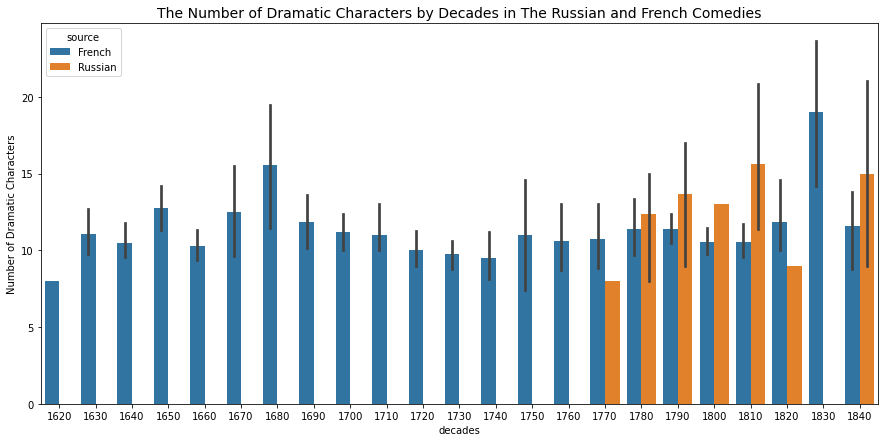

In [38]:
plt.figure(figsize=(15, 7))
plt.title('The Number of Dramatic Characters by Decades in The Russian and French Comedies', fontsize=14)
sns.barplot(x=combined_df['decades'], y=combined_df['num_present_characters'], hue=combined_df['source'])
plt.ylabel('Number of Dramatic Characters')
plt.show()

#### The Number of Dramatic Characters
The mean value was higher in the Russian comedies in every decade except for these two decades:
- In the 1770s, the mean value was 10.75 in French vs. 8 in Russian
- In the 1820s, it was 11.82 in French vs. 9 in Russian. 

However, it is worth mentioning that older French comedies of the 1680s had a high mean number of dramatic characters (15.57). The French comedies of the 1830s had the highest mean number of dramatic characters (19). During this decade, there were no Russian five-act verse comedies.

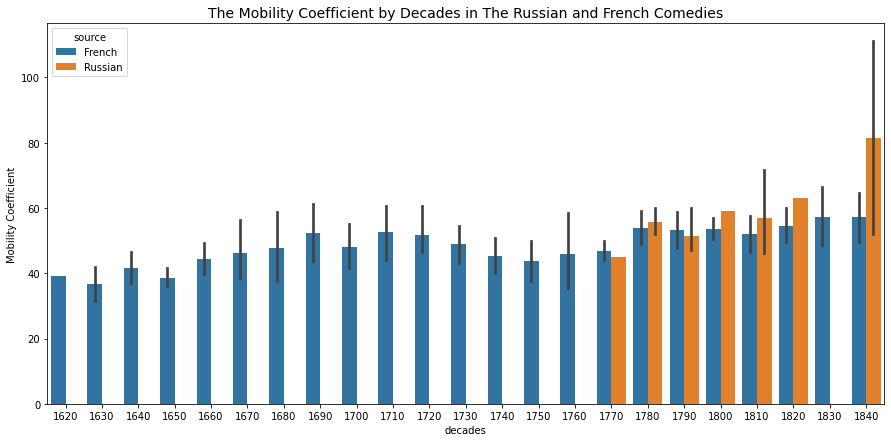

In [39]:
plt.figure(figsize=(15, 7))
plt.title('The Mobility Coefficient by Decades in The Russian and French Comedies', fontsize=14)
sns.barplot(x=combined_df['decades'], y=combined_df['mobility_coefficient'], hue=combined_df['source'])
plt.ylabel('Mobility Coefficient')
plt.show()

In [40]:
russian_comedies_df[russian_comedies_df.decades == 1840][['title', 
                                                          'last_name', 
                                                          'first_name', 
                                                          'creation_date', 
                                                          'mobility_coefficient']]

,title,last_name,first_name,creation_date,mobility_coefficient
14,Novaia shkola muzhei,Zotov,Rafail,1842,52
15,Zhiteiiskaia shkola,Grigor’ev,Petr,1849,111


#### The Mobility Coefficient
The mean mobility coefficient was slightly higher in the Russian comedies in every decade except for two decades:
- In the 1770s, 46.88 in French vs. 45 in Russian
- In the 1790s, 53.08 in French vs. 51.33 in Russian.

The mean mobility coefficient in the Russian comedies of the 1840s was much higher than the corresponding French: 81.5 vs. 57.2. More investigation showed that there were two Russian five-act verse comedies in the 1840s: Rafail Zotov's *Novaia shkola muzhei* (1842) that had a reasonble mobility coefficient (52) and Petr Grigor’ev's *Zhiteiiskaia shkola* (1849) that had an extremely high mobility coefficient of 111.

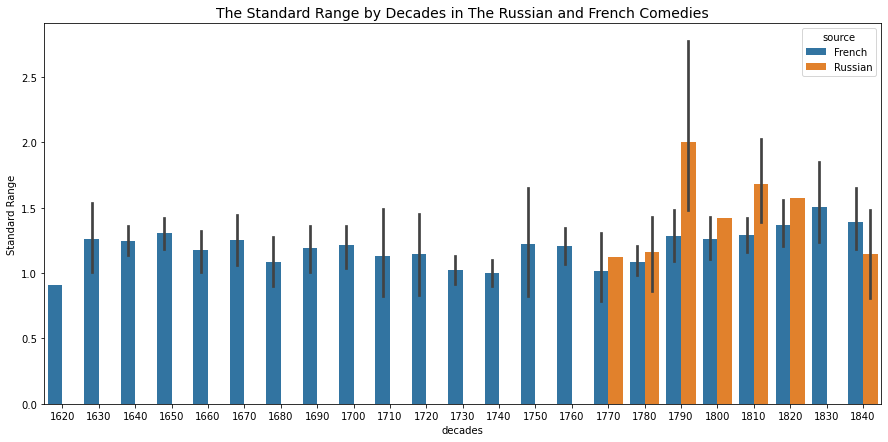

In [41]:
plt.figure(figsize=(15, 7))
plt.title('The Standard Range by Decades in The Russian and French Comedies', fontsize=14)
sns.barplot(x=combined_df['decades'], y=combined_df['sigma_iarkho'], hue=combined_df['source'])
plt.ylabel('Standard Range')
plt.show()

#### The Standard Range of The Speaking Characters
The standard range of the number of speaking characters: the mean value was higher in the Russian comedies of every decade except for the 1840s, 1.39 in French vs. 1.15 in Russian. The Russian five-act verse comedies of the 1770s (1.12) and 1780s (1.16) had a higher sigma than the French comedies of the same decaces. However, the French comedies of the preceding decades had higher sigmas (e.g., 1.3 in the 1650s, 1.26 in the 1630s, 1.25 in the 1670s, 1.24 in the 1640s, 1.21 in the 1700s, 1.23 in the 1750s, and 1.20 in the 1760s.

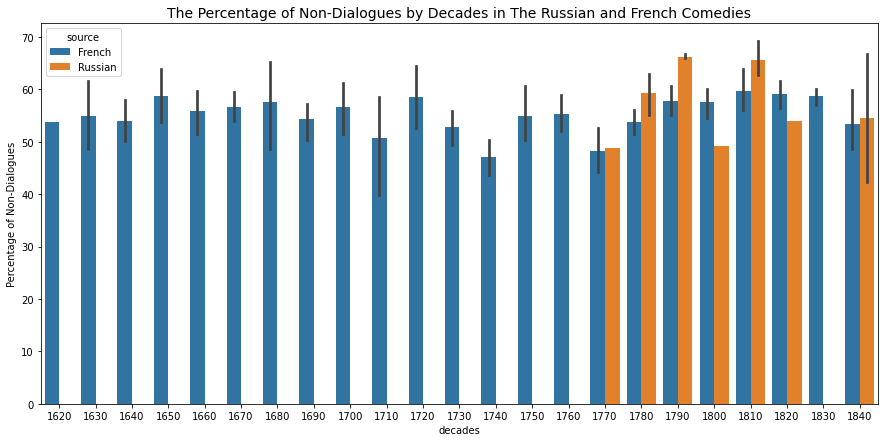

In [42]:
plt.figure(figsize=(15, 7))
plt.title('The Percentage of Non-Dialogues by Decades in The Russian and French Comedies', fontsize=14)
sns.barplot(x=combined_df['decades'], y=combined_df['percentage_non_dialogues'], hue=combined_df['source'])
plt.ylabel('Percentage of Non-Dialogues')
plt.show()

#### The Percentage of Non-Dialogues
The mean percentage of non-dialogues was higher in every decade in the Russian comedies except for three decades:
- The 1800s, 57.60% in French vs. 49.15% in Russian
- The 1820s, 59.01% in French vs.53.97% in Russian, 1830s, 58.66% in French vs. 53.97%

Despite the fact that the mean percentage of polylogues tended to be higher in the Russian comedies during the same decade, the French comedies of the preceding decades had higher or comparable mean values: the 1650s - 48.94%, the 1640s - 43.47%, the 1680s - 43.31%.

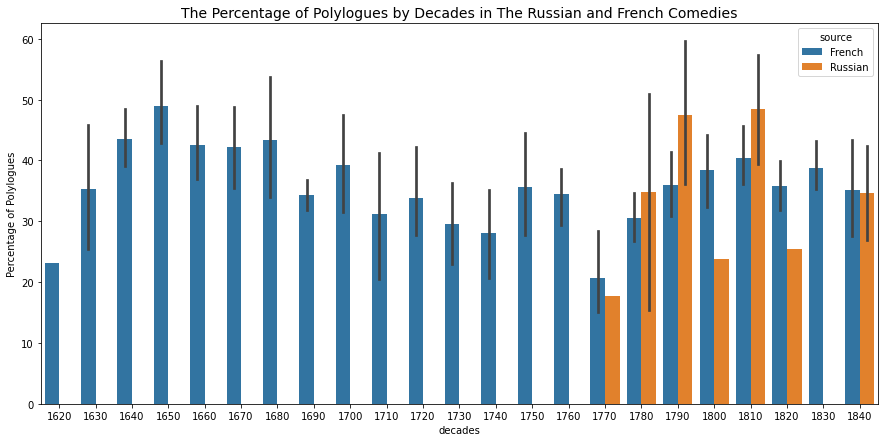

In [43]:
plt.figure(figsize=(15, 7))
plt.title('The Percentage of Polylogues by Decades in The Russian and French Comedies', fontsize=14)
sns.barplot(x=combined_df['decades'], y=combined_df['percentage_polylogues'], hue=combined_df['source'])
plt.ylabel('Percentage of Polylogues')
plt.show()

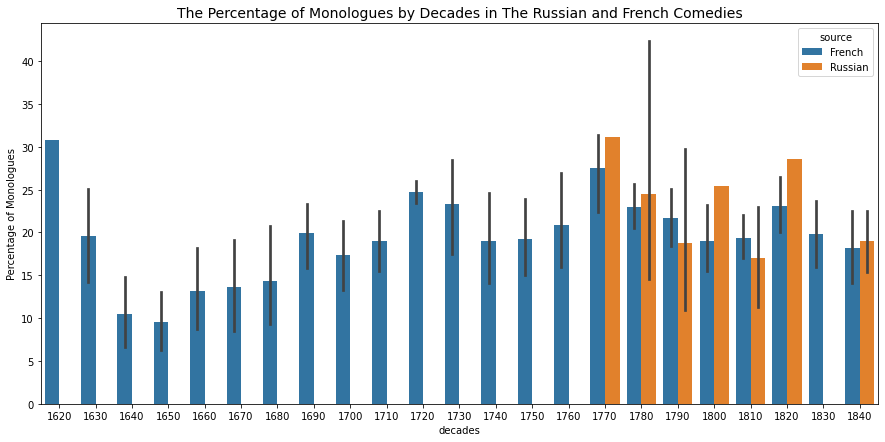

In [44]:
plt.figure(figsize=(15, 7))
plt.title('The Percentage of Monologues by Decades in The Russian and French Comedies', fontsize=14)
sns.barplot(x=combined_df['decades'], y=combined_df['percentage_monologues'], hue=combined_df['source'])
plt.ylabel('Percentage of Monologues')
plt.show()

In [45]:
combined_df[combined_df.decades == 1620][['title', 'date', 'last_name', 'first_name', 'percentage_monologues']]

,title,date,last_name,first_name,percentage_monologues
0,Mélite ou Les fausses lettres,1629.0,Corneille,Pierre,30.77


#### The Percentage of Monologues
The mean percentage of monologues was higher in two periods in the French tradition.
- In the 1790s, it was 21.66 in French vs. 18.72 in the Russian tradition. 
- In the 1810s, the mean percentage of monologues was 19.32% in the French and 16.97% in the Russian tradition.

The only French comedy of the 1620s, Pierre Corneille's *Mélite ou Les fausses lettres* (1629) had a high percentage of monologues - 30.77%. According to Iarkho, the percentage of monologues in Pierre Corneille's comedies was 25.3% (Iarkho 2006, 445).

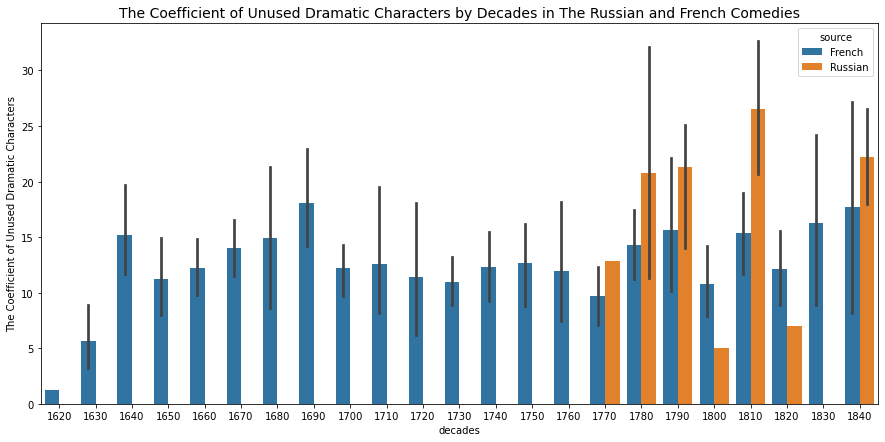

In [46]:
plt.figure(figsize=(15, 7))
plt.title('The Coefficient of Unused Dramatic Characters by Decades in The Russian and French Comedies', fontsize=14)
sns.barplot(x=combined_df['decades'], y=combined_df['coefficient_unused'], hue=combined_df['source'])
plt.ylabel('The Coefficient of Unused Dramatic Characters')
plt.show()

#### The Coefficient of Unused Dramatic Characters
The mean coefficient of unused dramatic characters tended to be higher in the Russian comedy every decade, except for the 1800s and 1820s. 
- In the French comedies of the 1800s, it was 10.8 vs. 5 in the Russian. 
- In the 1820s, the mean coefficient of unused dramatic characters was 12.09 in French vs. 6.96 in the Russian comedies.

We noticed that the coefficient of unused dramatic characters in the Russian comedy oscillated by decades: 5 in the 1800s, 26.53 in the 1810s, 6.96 in the 1820s, 22.26 in the 1840s. This oscillation could be a sign of different stylistic preferences of the corresponding decades.

Additionally, the French comedies of the 1690s and the 1640s had relatively high mean coefficients of unused dramatic characters - 18.07 and 15.22 respectively.

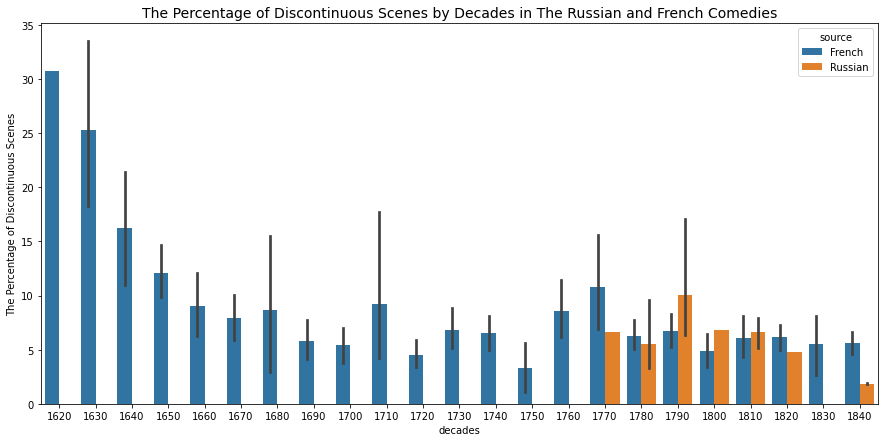

In [47]:
plt.figure(figsize=(15, 7))
plt.title('The Percentage of Discontinuous Scenes by Decades in The Russian and French Comedies', fontsize=14)
sns.barplot(x=combined_df['decades'], y=combined_df['discontinuous_scenes'], hue=combined_df['source'])
plt.ylabel('The Percentage of Discontinuous Scenes')
plt.show()

#### The Percentage of Discontinuous Scenes
The mean percentage of discontinuous scenes was higher in the French comedies in almost half of the decades:
- In the 1770s, the mean percentage of discontinuous scenes was 10.79% in the French and 6.67% in the Russian comedies. 
- In the 1780s, the gap decreased but still the French comedies on average more discontinuous scenes: 6.29% in the French and 5.53% in the Russian tradition. 
- In the 1820s, 5.53% of the French comedies' scenes were discontinuous and 4.76% of the Russian comedies' scenes.  
- In the 1840s, the mean percentage of discontinuous scenes in the French tradition was 5.62%  and 1.86% in Russian.

In general, the French comedies during earlier decades tended to have a high percentage of discontinuous scenes that was gradually declining from 30.77% in the 1620s to 7.92% in the 1670s followed by a more complex alternting development.

### Observations:
Despite that in many cases, the mean decade values of the features in the Russian five-act comedies were higher than the contemporaneous French, we noticed that the French comedies of the preceding decades had higher or similar mean values. The features included the number of dramatic characters, the percentage of polylogues, the percentage of monologues, and the percentage of discontinuous scenes.

### Speech Distribution in the French Five-Act Comedy In Verse in Period One

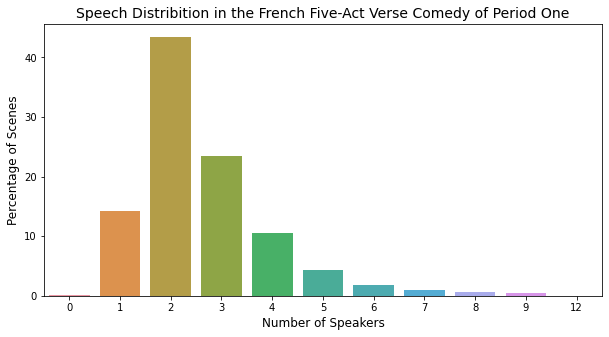

In [48]:
plot_speech_distribution(speech_distribution_by_period(french_period_one), 
                         'Speech Distribition in the French Five-Act Verse Comedy of Period One')

In [49]:
speech_distribution_by_period(french_period_one)

,0,1,2,3,4,5,6,7,8,9,12
number_of_speakers,,,,,,,,,,,
percentage_of_scenes,0.06,14.16,43.43,23.42,10.6,4.39,1.86,0.91,0.68,0.48,0.01


N.Gillet de la Tessonnerie's *Le Campagnard* (1657) and Noël Lebreton, sieur de Hauteroche's *Crispin musicien* (1674) have scenes with no speakers.

In [50]:
np.sum(speech_distribution_by_period(french_period_one).values[0][7:])

2.08

### Speech Distribution in the French Five-Act Comedy In Verse in Period Two (First Part)

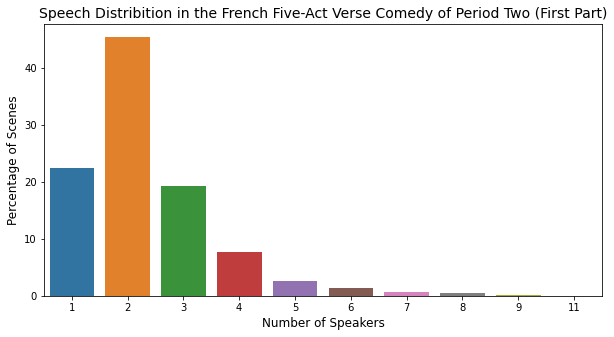

In [51]:
plot_speech_distribution(speech_distribution_by_period(french_period_two_first_part), 
                         'Speech Distribition in the French Five-Act Verse Comedy of Period Two (First Part)')

In [52]:
speech_distribution_by_period(french_period_two_first_part)

,1,2,3,4,5,6,7,8,9,11
number_of_speakers,,,,,,,,,,
percentage_of_scenes,22.52,45.49,19.32,7.63,2.64,1.3,0.59,0.41,0.08,0.03


In [53]:
np.sum(speech_distribution_by_period(french_period_two_first_part).values[0][6:])

1.11

### Speech Distribution in the French Five-Act Comedy In Verse in Period Two (Second Part)

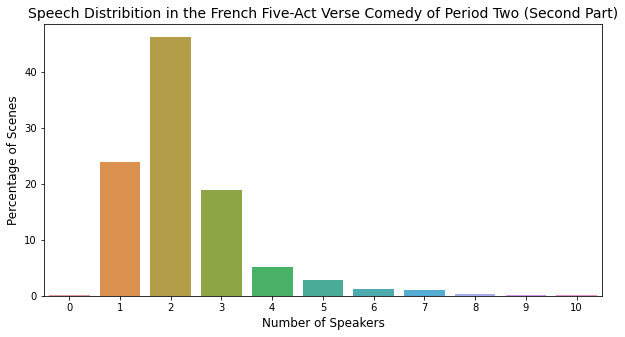

In [54]:
plot_speech_distribution(speech_distribution_by_period(french_period_two_second_part), 
                         'Speech Distribition in the French Five-Act Verse Comedy of Period Two (Second Part)')

In [55]:
speech_distribution_by_period(french_period_two_second_part)

,0,1,2,3,4,5,6,7,8,9,10
number_of_speakers,,,,,,,,,,,
percentage_of_scenes,0.06,23.87,46.27,18.92,5.15,2.84,1.3,1.0,0.35,0.19,0.06


In [56]:
np.sum(speech_distribution_by_period(french_period_two_second_part).values[0][7:])

1.6

Marc-Antoine-Jacques Rochon de Chabannes's *Le Jaloux* (1784) has a scene with no speakers.

### Speech Distribution in the French Five-Act Comedy In Verse in Period Three

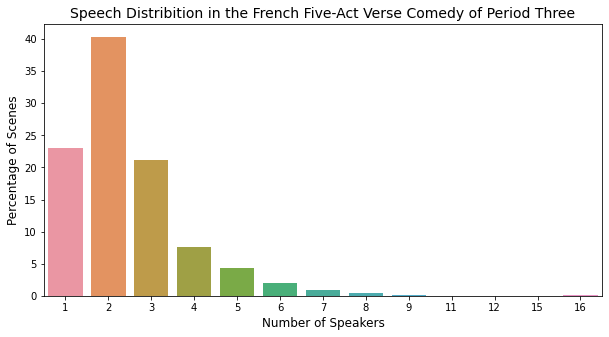

In [57]:
plot_speech_distribution(speech_distribution_by_period(french_period_three), 
                         'Speech Distribition in the French Five-Act Verse Comedy of Period Three')

In [58]:
speech_distribution_by_period(french_period_three)

,1,2,3,4,5,6,7,8,9,11,12,15,16
number_of_speakers,,,,,,,,,,,,,
percentage_of_scenes,23.01,40.33,21.09,7.59,4.31,1.96,0.88,0.5,0.18,0.04,0.04,0.02,0.05


In [59]:
np.sum(speech_distribution_by_period(french_period_three).values[0][6:])

1.71

### Speech Distribution in the Russian Five-Act Comedy In Verse in The Tentative Period One

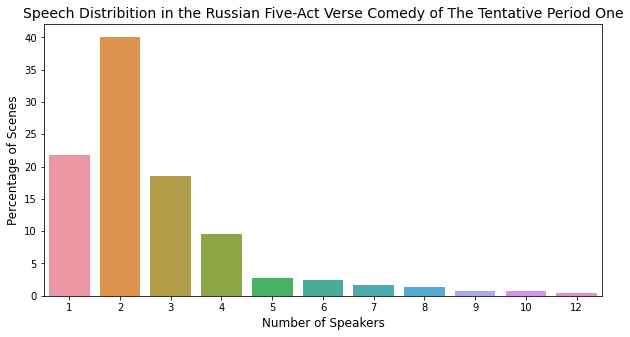

In [60]:
plot_speech_distribution(speech_distribution_by_period(russian_period_one), 
                         'Speech Distribition in the Russian Five-Act Verse Comedy of The Tentative Period One')

In [61]:
speech_distribution_by_period(russian_period_one)

,1,2,3,4,5,6,7,8,9,10,12
number_of_speakers,,,,,,,,,,,
percentage_of_scenes,21.84,40.06,18.58,9.53,2.79,2.44,1.7,1.29,0.71,0.71,0.36


In [62]:
round(np.sum(speech_distribution_by_period(russian_period_one).values[0][6:]), 2)

4.77

### Speech Distribution in the Russian Five-Act Comedy In Verse in The Tentative Period Two

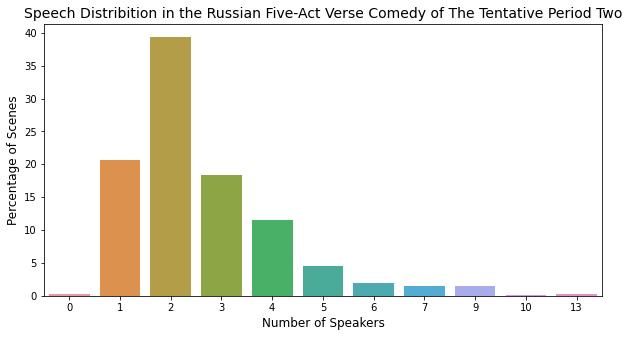

In [63]:
plot_speech_distribution(speech_distribution_by_period(russian_period_two), 
                         'Speech Distribition in the Russian Five-Act Verse Comedy of The Tentative Period Two')

Note that in the Russian corpus there is a comedy that has zero speakers in a scene, Boris Fedorov's *Chudnya vstrechi* (1818).

In [64]:
speech_distribution_by_period(russian_period_two)

,0,1,2,3,4,5,6,7,9,10,13
number_of_speakers,,,,,,,,,,,
percentage_of_scenes,0.3,20.66,39.36,18.39,11.45,4.58,1.99,1.42,1.45,0.17,0.22


In [65]:
round(np.sum(speech_distribution_by_period(russian_period_two).values[0][7:]), 2)

3.26

### Summary:

#### Comparison of The Speech Distribution in the Russian tentative Period One and the French Period Two (second part):
The maximum number of speaking characters in the Russian tentative Period One was 12; 4.77% had above six speakers. In the French Period Two (second part), the maximum number of speakers was 10, with 1.6% of the scenes having over six speakers. In the French Period Two (second part, there was a comedy with a scene that had no speakers - Marc-Antoine-Jacques Rochon de Chabannes's *Le Jaloux* (1784). In the Russian tentative Period One, there were no such comedies.


#### Comparison of The Speech Distribution in the Russian tentative Period Two and the French Period Three:
The maximum number of speakers in the Russian tentative Period Two was 13, with 3.26% of the scenes having over six speakers. In the French Period Three, the maximum number of speakers was 16, with 1.71% of the scenes having over 6 speakers. In the Russian tentative Period Two, there was one comedy with a scene without any speakers (Boris Fedorov's *Chudnya vstrechi* (1818)). In the French Period Three, there were no such comedies.

### Additional Comparisons:

#### Comparison of The Speech Distribution in the Russian tentative Period One and the French Period Two (first part):
The maximum number of speaking characters in the Russian tentative Period One was 12; 4.77% had above six speakers.  In the French Period Two (first part), the maximum number of speakers was 11, with 1.11% having over 6 speakers. Neither Russian nor French comedies of the above mentioned periods had scenes without speakers.

#### Comparison of The Speech Distribution in the Russian tentative Period One and the French Period One:
The maximum number of speaking characters in the Russian tentative Period One was 12; 4.77% had above six speakers. In the French Period One, the maximum number of speakers was also 12. However, only 2.08% of the scenes had over six speakers. In the French Periods One, two comedies had scenes without any speakers, N.Gillet de la Tessonnerie's Le Campagnard (1657) and Noël Lebreton, sieur de Hauteroche's Crispin musicien (1674). In the Russian tentative Period One, there were no such comedies.


### Contrastive Material

#### Load Contrastive Material Data

In [66]:
contr_data_df = pd.read_csv('../Contrastive_Material/Contrastive_Material_Data.csv')
contr_data_df['speech_distribution'] = contr_data_df['speech_distribution'].apply(make_list)
# sort by date
sorted_contr_data_df = contr_data_df.sort_values(by='date')

sorted_contr_data_df  = sorted_contr_data_df.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                           'percentage_non_duologues': 'percentage_non_dialogues',
                                                           'percentage_above_two_speakers': 'percentage_polylogues',
                                                            'percentage_scenes_with_discontinuous_change_characters': 
                                                            'discontinuous_scenes',
                                                            'sigma_iarkho': 'standard_range'})
sorted_contr_data_df['date'] = sorted_contr_data_df['date'].astype('int')
sorted_contr_data_df['last_name'] = sorted_contr_data_df['last_name'].str.strip()

shakespeare_df = sorted_contr_data_df[sorted_contr_data_df.last_name == 'Shakespeare'].copy()
goldoni_df = sorted_contr_data_df[sorted_contr_data_df.last_name == 'Goldoni'].copy()

### William Shakespeare (1582 - 1616)

In [67]:
shakespeare_summary = pd.DataFrame(shakespeare_df.describe().loc['mean', features]).round(2)
shakespeare_summary.columns = ['Shakespeare']

In [68]:
shakespeare_summary

,Shakespeare
num_present_characters,25.83
mobility_coefficient,78.00
standard_range,1.33
percentage_non_dialogues,61.76
percentage_polylogues,37.85
percentage_monologues,23.56
coefficient_unused,40.99
discontinuous_scenes,19.35


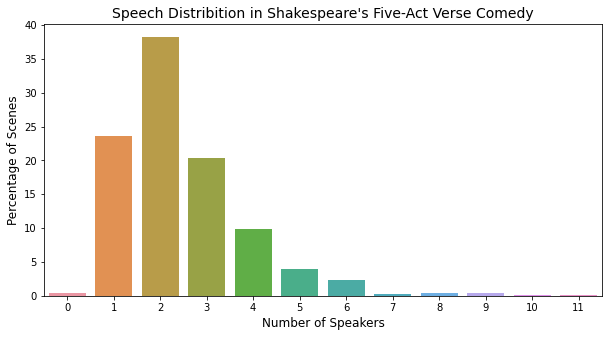

In [69]:
plot_speech_distribution(speech_distribution_by_period(shakespeare_df), 
                         'Speech Distribition in Shakespeare\'s Five-Act Verse Comedy')

### Shakespeare in The Context of Other Traditions:
1. The mean number of dramatic characters in Shakespeare's five-act verse comedies (25.83) was the highest observed in our material (French, Russian, and Contrastive).
2. The mean mobility coefficient in Shakespeare's comedies was the highest in our material (78).
3. The mean percentage of non-dialogues in Shakespeare's comedies was the highest observed (61.76%).
4. The mean percentage of monologues was also the highest in our material (23.56%).
5. The mean coefficient of unused dramatic characters is the highest observed (40.99%). The second highest coefficient of unused dramatic characters (in Goldoni, 17.28 does not come even close to that of Shakespeare). There are many dramatic characters who appear on stage but do not speak.
6. The mean percentage of discontinuous scenes in Shakespeare's comedies (19.35%) was the highest in our material.
7. The mean percentage of polylogues (37.85%) was slightly higher than that in the French Period Three (37.69) and lower than that in the Russian tentative Periods One (38.11%) and Two (39.68%).
8. The standard range of the speaking characters (1.33) was the same as the standard range of the speaking characters in the French Period Three. It was lower than in the Russian tentative Periods One (1.48) and Two (1.54). 
9. The maximum number of speaking dramatic characters was 11, which was the same as the maximum number of speakers in the French comedy of Period Two (first part). In the French Period Two (second half), the maximum number of speakers was lower (10).In the French Periods One and Three, the maximum number of speakers was higher (12 and 16 respectively). In the Russian tentative Periods One and Two, the maximum number of speakers was also higher (12 and 13).
17. In Shakespeare's comedies, there were scenes with no speakers (cf. in the French comedy of Periods One and Two (second part), there were scenes with no speakers. In the Russian tentative Period Two, there was a comedy with a scene without any speakers).

### Carlo Goldoni (1707 - 1793)

In [70]:
goldoni_summary = pd.DataFrame(goldoni_df.describe().loc['mean', features]).round(2)
goldoni_summary.columns = ['Goldoni']

In [71]:
goldoni_summary

,Goldoni
num_present_characters,11.88
mobility_coefficient,62.25
standard_range,1.21
percentage_non_dialogues,58.64
percentage_polylogues,38.74
percentage_monologues,19.65
coefficient_unused,17.28
discontinuous_scenes,9.80


In [72]:
french_sorted_comedies = french_sorted_comedies.rename(columns={'sigma_iarkho': 'standard_range'}).copy()

In [73]:
french_time_limit = french_sorted_comedies[french_sorted_comedies.date.between(1751, 1759)].copy()
french_cont = pd.DataFrame(french_time_limit.describe().loc['mean', features]).round(2).copy()

In [74]:
french_cont.columns = ['French_1751_to_1759']

In [75]:
french_cont

,French_1751_to_1759
num_present_characters,11.00
mobility_coefficient,43.80
standard_range,1.23
percentage_non_dialogues,54.96
percentage_polylogues,35.71
percentage_monologues,19.25
coefficient_unused,12.69
discontinuous_scenes,3.34


### Speech Distribution in Carlo Goldoni's Five-Act Comedies in Verse

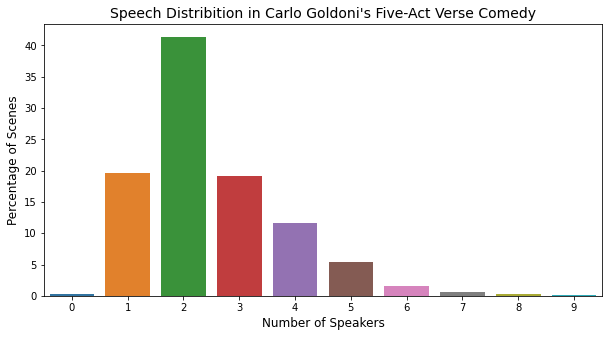

In [76]:
plot_speech_distribution(speech_distribution_by_period(goldoni_df), 
                         'Speech Distribition in Carlo Goldoni\'s Five-Act Verse Comedy')

In Goldoni's comedy I morbinosi, there is indeed a ball scene where no dramatic characters speak.

In [77]:
speech_distribution_by_period(goldoni_df)

,0,1,2,3,4,5,6,7,8,9
number_of_speakers,,,,,,,,,,
percentage_of_scenes,0.25,19.65,41.36,19.2,11.6,5.41,1.5,0.53,0.36,0.14


### French Five-Act Verse Comedies Between 1751 and 1759

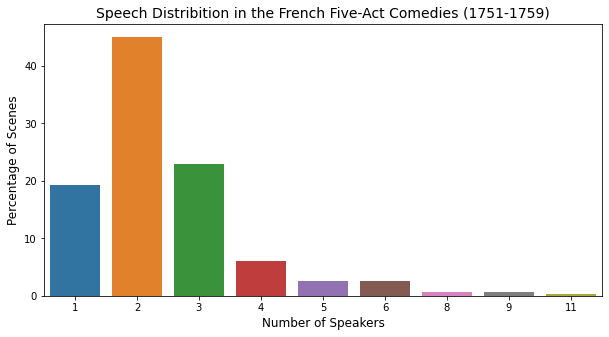

In [78]:
plot_speech_distribution(speech_distribution_by_period(french_time_limit), 
                         'Speech Distribition in the French Five-Act Comedies (1751-1759)')

In [79]:
speech_distribution_by_period(french_time_limit)

,1,2,3,4,5,6,8,9,11
number_of_speakers,,,,,,,,,
percentage_of_scenes,19.25,45.04,22.91,6.09,2.66,2.5,0.59,0.59,0.37


#### Comparison of Goldoni's Five-Act Verse Comedies with the Contemporaneous French Five-Act Comedies in Verse:
Carlo Goldoni wrote five-act verse comedies between 1751 and 1759. We will compare them with the French comedies from the same time frame.
1. Goldoni's comedies had higher mean values of the following features:
    - The mean number of dramatic characters (11.88 vs. 11 in French comedies);
    - The mobility coefficient (62.25 vs. 43.80);
    - The percentage of non-dialogues (58.64% vs. 54.96%);
    - The percentage of polylogues (38.74% vs. 35.71%).
    - The percentage of monologues (19.65% vs. 19.25%), which was only slightly higher in Goldoni;
    - The coefficient of unused dramatic characters (17.28 vs. 12.69);
    - The percentage of discontinuous scenes (9.80% vs. 3.34%).

2. Goldoni's comedies had lower mean values of the standard range of the number of speaking characters (1.21 in Goldoni vs. 1.23 in the French comedies), which was very still very close.
3. The maximum number of speakers in Goldoni's five-act comedies was nine, whereas, in the French five-act verse comedies of that time, it was 11.
3. Goldoni had a comedy with a scene without any speakers, whereas the French comedies of that period did not have such scenes.

#### Comparison of Goldoni's Five-Act Verse Comedies with the Russian Five-Act Comedies in Verse of the Tentative Period One:
1. Goldoni had higher mean values than the Russian comedies of the tentative Period One for the following features:
    - The mean number of dramatic characters (11.88 vs. 11.50 in Russian);
    - The mobility coefficient (62.25 vs. 53.17);
    - The percentage of polylogues (38.74% vs. 38.11%), which was only slightly higher;
    - The percentage of discontinuous scenes (9.8% vs. 6.05).

2. Goldoni had lower mean values than the Russian comedies of the tentative Period One for the following features:
    - The standard range of the number of speaking characters (1.21 vs. 1.48 in Russian);
    - The percentage of non-dialogues (58.64% vs. 59.94%);
    - The percentage of monologues (19.65% vs. 21.84%);
    - The coefficient of unused dramatic characters (17.28 vs. 19.04).
3. The maximum number of speakers in Goldoni was 9, whereas in the Russian comedies of the tentative Period One, it was 12.

#### Comparison of Goldoni's Five-Act Verse Comedies with the Russian Five-Act Comedies in Verse of the Tentative Period Two:
- Goldoni had lower mean values than the Russian five-act verse comedies of the tentative Period Two in all features, except for the mobility coefficient (62.25 in Goldoni vs. 61.60 in Russian comedies) and the percentage of discontinuous scenes (9.80 vs. 6.55 in Russian comedies).

- The maximum number of speakers in Goldoni was 9, whereas in the Russian comedies of the tentative Period Two, it was 13.

### The Closest Traditions

In this section, we will calculate the difference between different traditions and rank them in ascending order, from the smallest to largest difference. We will repeat this process for all features. Negative difference (e.g., the Russian tentative Period One and Goldoni difference = -0.375) would mean that Goldoni has a higher mean value of the feature than the Russian period.

In [80]:
goldoni_df = goldoni_df.rename(columns={'standard_range': 'sigma_iarkho', 'date': 'creation_date'})
shakespeare_df = shakespeare_df.rename(columns={'standard_range': 'sigma_iarkho', 'date': 'creation_date'})

In [81]:
difference_calculation('num_present_characters')

num_present_characters
	Russian tentative Period One and French Period Two (Second Part): 0.227
	Russian tentative Period One and French Period One: -0.307
	Russian tentative Period One and Goldoni: -0.375
	Russian tentative Period One and French Period Two (First Part): 1.224
	Russian tentative Period One and Shakespeare: -14.333


	Russian tentative Period Two and French Period Three: 2.737
	Russian tentative Period Two and Goldoni: 2.825
	Russian tentative Period Two and French Period One: 2.893
	Russian tentative Period Two and French Period Two (Second Part): 3.427
	Russian tentative Period Two and French Period Two (First Part): 4.424
	Russian tentative Period Two and Shakespeare: -11.133


	French Period One and Goldoni: -0.068
	French Period Three and Goldoni: 0.088
	French Comedies Between 1751 and 1759 and Goldoni: -0.602
	French Period Two (First Part) and Goldoni: -1.599
	French Period Three and Shakespeare: -13.87
	French Period One and Shakespeare: -14.026
	French Period 

In [82]:
difference_calculation('coefficient_unused')

coefficient_unused
	Russian tentative Period One and Goldoni: 1.754
	Russian tentative Period One and French Period Two (Second Part): 5.026
	Russian tentative Period One and French Period One: 6.867
	Russian tentative Period One and French Period Two (First Part): 7.006
	Russian tentative Period One and Shakespeare: -21.953


	Russian tentative Period Two and Goldoni: 4.113
	Russian tentative Period Two and French Period Two (Second Part): 7.384
	Russian tentative Period Two and French Period Three: 7.654
	Russian tentative Period Two and French Period One: 9.226
	Russian tentative Period Two and French Period Two (First Part): 9.364
	Russian tentative Period Two and Shakespeare: -19.595


	French Comedies Between 1751 and 1759 and Goldoni: -3.272
	French Period Three and Goldoni: -3.541
	French Period One and Goldoni: -5.113
	French Period Two (First Part) and Goldoni: -5.252
	French Period Two (Second Part) and Shakespeare: -26.979
	French Period Three and Shakespeare: -27.249
	Fren

In [83]:
difference_calculation('mobility_coefficient')

mobility_coefficient
	Russian tentative Period One and French Period Two (Second Part): 1.379
	Russian tentative Period One and French Period Two (First Part): 4.874
	Russian tentative Period One and Goldoni: -9.083
	Russian tentative Period One and French Period One: 11.347
	Russian tentative Period One and Shakespeare: -24.833


	Russian tentative Period Two and Goldoni: -0.65
	Russian tentative Period Two and French Period Three: 7.285
	Russian tentative Period Two and French Period Two (Second Part): 9.812
	Russian tentative Period Two and French Period Two (First Part): 13.307
	Russian tentative Period Two and Shakespeare: -16.4
	Russian tentative Period Two and French Period One: 19.781


	French Period Three and Goldoni: -7.935
	French Comedies Between 1751 and 1759 and Goldoni: -10.462
	French Period Two (First Part) and Goldoni: -13.957
	French Period One and Goldoni: -20.431
	French Period Three and Shakespeare: -23.685
	French Period Two (Second Part) and Shakespeare: -26.21

#### Features Describing Dramatic Characters and Their Movements:
1. **The number of dramatic characters**:
  - the Russian tentative Period One was most similar to the contemporaneous French second half of Period Two (only 0.227 difference). The second most similar period tradition was the French Period One (-0.307, where the negative number means that the French Period One had a higher mean number of dramatic characters). The third most similar tradition was Goldoni (difference = -0.375).
  
  - the Russian tentative Period Two was not as similar to other traditions as the tentative Period One. It was the most similar to the contemporaneous French Period Three (difference = 2.737), followed by Goldoni (2.825), and the French Period One (difference = 2.893).
   - the French comedies of Period One were most similar to Goldoni (difference = 0.068), followed by the French comedies of Period Three (difference = 0.088), and French comedies contemporaneous to Goldoni (difference = -0.602).
  - Both Russian tentative periods were extremely different from Shakespeare. The Russian tentative Period One had a -14.333 difference with Shakespeare. The Russian tentative Period Two had a -11.133 difference with Shakespeare).
  - French comedies of all periods were also very different from Shakespeare. The least different were the French Period Three  (-13.87 difference. The next least difference was with the French Period One ((-14.026), followed by the second half of the French Period Two (difference = -14.561). The French Period Three was the most dissimilar to Shakespeare (difference = -15.557).
  -  Goldoni and Shakespeare were almost as dissimilar as the French and Russian traditions with Shakespeare (difference = -13.958).

  
2. **The coefficient of unused dramatic characters**:
   - the Russian tentative Period One was the closest to Goldoni (difference = 1.754), followed by the contemporaneous French comedies (5.026), and French comedies of the first part of Period One (difference = 6.867).
   - the Russian tentative Period Two was most similar to Goldoni, though not as much as the Russian tentative Period One (difference = 4.113), followed by the French comedies of the second part of Period Two (difference = 7.384), and period Three (difference = 7.654).
   - the French comedies contemporaneous to Goldoni were most similar to him (difference = -3.272), followed by the French comedies of Period Three (-3.541), and Period One (difference = -5.113).
   - Both tentative Periods of the Russian comedies were very far from Shakespeare (difference = -21.953 and difference = -19.595).
   - French comedies of all periods were even further away from Shakespeare, with the smallest difference observed in the second part of Period Two (difference = -26.979).
   - Goldoni and Shakespeare had a slightly smaller but still very large difference (difference = -23.708).

    
3. **The mobility coefficient**:
  - the Russian tentative Period One was most similar to the contemporaneous French comedies (difference = 1.379), followed by the first half of Period Two (difference = 4.874), and Goldoni (difference = -9.083). 
  - the Russian tentative Period Two was most similar to Goldoni (difference = -0.65), followed by the contemporaneous French Period Three (difference = 7.285), and the second half of the French Period Two (difference = 9.812).
   - the French comedies of Period Three were most similar to Goldoni (difference = -7.935).
   - the Russian comedies of both tentative periods were dissimilar to Shakespeare, however, Period Two was less dissimilar than Period One (difference with the tentative Period One = -24.833, with the Period Two = -16.4).
   - All French periods were also dissimilar from Shakespeare (with the difference ranging from -23.685 in the French Period Three to -36.181 in the French Period One).
   - Shakespeare and Goldoni were also rather distant (difference = -15.75).
        
    
4. **The percentage of discontinuous scenes**:
  - the Russian tentative Period One had the highest similarity with the first part of the French Period Two (difference = -0.442), followed by the contemporaneous French comedies (difference = -1.502), and Goldoni (difference = -3.747).
  - the Russian tentative Period Two also had the highest similarity with the first part of the French Period Two (0.062), followed by contemporaneous French comedies (difference = 0.724).
  - Russian comedies of both periods were very dissimilar from Shakespeare (difference = -13.301 and difference = -12.797).
  - French comedies contemporaneous to Goldoni were most similar to him (difference = -2.245).
  - French comedies of all periods were dissimilar with Shakespeare, with differences ranging from 3.575 (Period One) to 13.521 in Period Three. 
  - Shakespeare and Goldoni had a large difference (difference = -9.554).

In [84]:
difference_calculation('discontinuous_scenes')

discontinuous_scenes
	Russian tentative Period One and French Period Two (First Part): -0.442
	Russian tentative Period One and French Period Two (Second Part): -1.502
	Russian tentative Period One and Goldoni: -3.747
	Russian tentative Period One and French Period One: -7.323
	Russian tentative Period One and Shakespeare: -13.301


	Russian tentative Period Two and French Period Two (First Part): 0.062
	Russian tentative Period Two and French Period Three: 0.724
	Russian tentative Period Two and French Period Two (Second Part): -0.998
	Russian tentative Period Two and Goldoni: -3.243
	Russian tentative Period Two and French Period One: -6.819
	Russian tentative Period Two and Shakespeare: -12.797


	French Comedies Between 1751 and 1759 and Goldoni: -2.245
	French Period Two (First Part) and Goldoni: -3.305
	French Period One and Goldoni: 3.575
	French Period Three and Goldoni: -3.967
	French Period One and Shakespeare: -5.978
	French Period Two (Second Part) and Shakespeare: -11.799


In [85]:
difference_calculation('sigma_iarkho')

sigma_iarkho
	Russian tentative Period One and Shakespeare: 0.145
	Russian tentative Period One and French Period One: 0.249
	Russian tentative Period One and Goldoni: 0.269
	Russian tentative Period One and French Period Two (Second Part): 0.338
	Russian tentative Period One and French Period Two (First Part): 0.359


	Russian tentative Period Two and Shakespeare: 0.212
	Russian tentative Period Two and French Period Three: 0.213
	Russian tentative Period Two and French Period One: 0.316
	Russian tentative Period Two and Goldoni: 0.336
	Russian tentative Period Two and French Period Two (Second Part): 0.406
	Russian tentative Period Two and French Period Two (First Part): 0.426


	French Period Three and Shakespeare: -0.0
	French Period One and Goldoni: 0.02
	French Comedies Between 1751 and 1759 and Goldoni: -0.07
	French Period Two (First Part) and Goldoni: -0.091
	French Period One and Shakespeare: -0.104
	French Period Three and Goldoni: 0.123
	French Period Two (Second Part) and 

In [86]:
difference_calculation('percentage_non_dialogues')

percentage_non_dialogues
	Russian tentative Period One and Goldoni: 1.305
	Russian tentative Period One and Shakespeare: -1.815
	Russian tentative Period One and French Period One: 3.83
	Russian tentative Period One and French Period Two (Second Part): 6.216
	Russian tentative Period One and French Period Two (First Part): 6.576


	Russian tentative Period Two and Shakespeare: -1.122
	Russian tentative Period Two and Goldoni: 1.997
	Russian tentative Period Two and French Period Three: 2.512
	Russian tentative Period Two and French Period One: 4.522
	Russian tentative Period Two and French Period Two (Second Part): 6.909
	Russian tentative Period Two and French Period Two (First Part): 7.269


	French Period Three and Goldoni: -0.515
	French Period One and Goldoni: -2.525
	French Period Three and Shakespeare: -3.634
	French Comedies Between 1751 and 1759 and Goldoni: -4.912
	French Period Two (First Part) and Goldoni: -5.272
	French Period One and Shakespeare: -5.645
	French Period Two

In [87]:
difference_calculation('percentage_polylogues')

percentage_polylogues
	Russian tentative Period One and Shakespeare: 0.259
	Russian tentative Period One and Goldoni: -0.63
	Russian tentative Period One and French Period One: -4.704
	Russian tentative Period One and French Period Two (First Part): 5.843
	Russian tentative Period One and French Period Two (Second Part): 8.303


	Russian tentative Period Two and Goldoni: 0.941
	Russian tentative Period Two and Shakespeare: 1.829
	Russian tentative Period Two and French Period Three: 1.983
	Russian tentative Period Two and French Period One: -3.134
	Russian tentative Period Two and French Period Two (First Part): 7.413
	Russian tentative Period Two and French Period Two (Second Part): 9.874


	French Period Three and Shakespeare: -0.153
	French Period Three and Goldoni: -1.042
	French Period One and Goldoni: 4.074
	French Period One and Shakespeare: 4.963
	French Period Two (First Part) and Shakespeare: -5.584
	French Period Two (First Part) and Goldoni: -6.472
	French Period Two (Secon

In [88]:
difference_calculation('percentage_monologues')

percentage_monologues
	Russian tentative Period One and French Period Two (First Part): 0.767
	Russian tentative Period One and Shakespeare: -1.719
	Russian tentative Period One and French Period Two (Second Part): -2.032
	Russian tentative Period One and Goldoni: 2.183
	Russian tentative Period One and French Period One: 8.658


	Russian tentative Period Two and French Period Three: 0.301
	Russian tentative Period Two and French Period Two (First Part): -0.415
	Russian tentative Period Two and Goldoni: 1.001
	Russian tentative Period Two and Shakespeare: -2.901
	Russian tentative Period Two and French Period Two (Second Part): -3.214
	Russian tentative Period Two and French Period One: 7.476


	French Period Two (Second Part) and Shakespeare: 0.313
	French Period Three and Goldoni: 0.7
	French Period Two (First Part) and Goldoni: 1.416
	French Period Two (First Part) and Shakespeare: -2.486
	French Period Three and Shakespeare: -3.202
	French Comedies Between 1751 and 1759 and Goldoni

#### Features Describing Dramatic Characters' Speech:   
1. **The standard range of the number of speaking characters**:
  - the Russian tentative Period One was the closest to Shakespeare (difference =0.145), followed by the French Period One (0.249).
  - the Russian tentative Period Two also was the cloest to Shakespeare (difference = 0.212), followed by the contemporaneous French comedies (difference = 0.213).
  - the French Period Three had no difference with Shakespeare.
  - the French Period One had the smallest difference with Goldoni (difference = 0.02), followed by the contemporaneous French comedies (difference = -0.07).
  - Shakespeare and Goldoni had a very small difference (difference = -0.124).


2. **The percentage of non-dialogues**:
  - the Russian tentative Period One was the closest to Goldoni (difference = 1.305), followed by Shakespeare (difference = -1.815).
  - the Russian tentative Period Two was most similar with Shakespeare (difference = -1.122), followed by Goldoni (difference = 1.997).
  - the French, which was the closest to Shakespeare, was Period Three (difference = -3.634).
  - French Period Three was also the closest to  Goldoni (difference = -0.515).
  - Shakespeare and Goldoni had a rather small difference (difference = -3.12).
    
    
3. **The percentage of polylogues**:
  - the Russian tentative Period One had the highest similarity with Shakespeare (difference = 0.259), followed by Goldoni (-0.63).
  - the Russian tentative Period Two was most similar with Goldoni (difference=0.941), followed by Shakespeare (1.829).
  - the French Period Three had the highest similarity with Shakespeare (difference = -0.153).
  - the French Period was also the period in the French history, which was most similar to Shakespere (difference=  -1.042).
  - Shakespeare and Goldoni had a very small difference (difference = 0.889)
  
  
4. **The percentage of monologues**:
  - the Russian tentative Period One was most similar to the first part of the French Period Two (difference = 0.767), followed by Shakespeare (difference = -1.719). 
  - the Russian tentative Period Two was most similar to the contemporaneous French Period Three (difference = 0.301), followed by the first part of the French Period Two (difference = -0.415).
  - the French comedies of the second part of of Period Two had smallest difference with Shakespeare (difference = 0.313).
  - the French comedies of Period Three were most similar to Goldoni (difference =  0.7)
  - Shakespeare and Goldoni were reasonably similar (difference = -3.902).

## Conclusions:
1. In two tentative periods, Russian comedies had higher values than the contemporaneous French. There could be a few possible explanations for this. The Russian tradition could have been mainly influenced by a specific substratum of the French comedians who were popular in Russia at that time, instead of an entire corpus of contemporaneous five-act verse comedies. Another possiblity could have been that a specific group of Russian comedies was influences by the French comedies, while the other group experienced the influence of another national tradition (or the influence of another genre).

2. Despite having higher values than the contemporaneous French comedies, for all features describing dramatic characters and their movements except for the coefficient of unused dramatic characters, either contemporaneousFrench comedies or French comedies of preceding periods were the most similar tradition. For the coefficient of unused dramatic characters, Goldoni's comedies were the most similar tradition, followed by the contemporaneous French tradition. Based on these features describing dramatic characters and their movements, the Russian, the French, and the Italian  (as represented by Goldoni) traditions were very dissimilar from Shakespeare. These features most likely differentiated the continental, French-Italian tradition, which served as a model for the Russians, from the English tradition.


3. Based on the features describing dramatic characters speech, Shakespeare was far less "distant" from the continental tradition than based on the features describing dramatic characters and their movements. For all features, except the percentage of monologues, Shakespeare's comedies were among the top two most similar traditions to the Russian comedies. For two of them (the percentage of non-dialogues and the percentage of polylogues), Goldoni's comedies were either the first or second most similar traditions. The behavior of the percentage of monologues was somewhat different. Here, it was the French tradition, either of the preceding or contemporaneous periods, which was most similar to the Russian tradition. For all features, except for the percentage of monologues, the French Period Three was the most similar to Shakespeare - for the percentage of monologues, the second part of Period Two was most similar to Shakespeare. For all features, the French Period Three was the most similar period to Goldoni, which could be a sign of the influence of Italian tradition on the subsequent French tradition. In general, the speech-based features revealed more similarities between the continental and the English comic tradition - they appear to reflect a shared European taste.

## Part 2. Open-Form Scores

The open-form score measures how experimental a style of a particular tradition during a specified decade is. Generation of open-form scores is described in detail in the following notebook: https://github.com/innawendell/European_Comedy/blob/master/Analyses/Open_Form_Scores_Evolution.ipynb. In our current analysis, we will calculate open-form scores for each tradition (Russian five-act verse comedies, French five-act verse comedies as well as Shakespeare's and Goldoni's five-act comedies in verse) by decades. Finally, we will trace and compare the evolution of these traditions.

In [89]:
french_original_comedies['decades'] = french_original_comedies.date.apply(decade)

In [90]:
summary_french = scores_calculation(french_original_comedies, True)

In [91]:
russian_comedies_df = russian_comedies_df.rename(columns={'standard_range': 'sigma_iarkho'})
summary_russian = scores_calculation(russian_comedies_df, True, french_original_comedies)

In [92]:
goldoni_df['decades'] = goldoni_df.creation_date.apply(decade)
summary_goldoni = scores_calculation(goldoni_df , True, french_original_comedies)

In [93]:
shakespeare_df['decades'] = shakespeare_df.creation_date.apply(decade)
summary_shakespeare = scores_calculation(shakespeare_df , True, french_original_comedies)

### Open-Form Scores For Shakespeare

In [94]:
summary_shakespeare

,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
decades,,,,,,
1600,5.01,3.52,0.03,-0.09,-0.52,1.59
1590,3.01,1.74,0.52,0.17,-0.60,0.97


### Open-Form Scores For Goldoni

In [95]:
summary_goldoni

,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
decades,,,,,,
1750,0.12,1.18,-0.04,0.13,-0.13,0.25


### Open-Form Scores For Russian Five-Act Verse Comedies

In [96]:
summary_russian

,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
decades,,,,,,
1810,1.12,0.73,1.31,0.91,0.17,0.85
1790,0.60,0.28,2.23,0.83,-0.03,0.78
1840,0.96,2.77,-0.21,-0.19,-0.05,0.66
1800,0.42,0.92,0.57,-1.06,-0.78,0.01
1780,0.25,0.64,-0.17,-0.18,-0.68,-0.03
1820,-0.64,1.24,1.01,-0.93,-1.13,-0.09
1770,-0.91,-0.24,-0.28,-1.54,-1.41,-0.88


### Open-Form Scores For French Five-Act Verse Comedies

In [97]:
summary_french

,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
decades,,,,,,
1830,2.20,0.98,0.57,0.13,-0.06,0.76
1650,0.31,-0.75,0.25,0.90,1.02,0.35
1680,0.96,0.08,-0.39,0.51,0.42,0.32
1670,0.45,0.09,0.10,0.43,0.50,0.31
1840,-0.02,0.90,0.42,-0.12,0.07,0.25
1660,-0.01,-0.50,0.30,0.46,0.68,0.19
1810,-0.19,0.28,0.30,0.38,-0.08,0.14
1790,0.05,0.50,0.18,-0.03,-0.30,0.08
1800,-0.14,0.49,0.05,0.04,-0.05,0.08


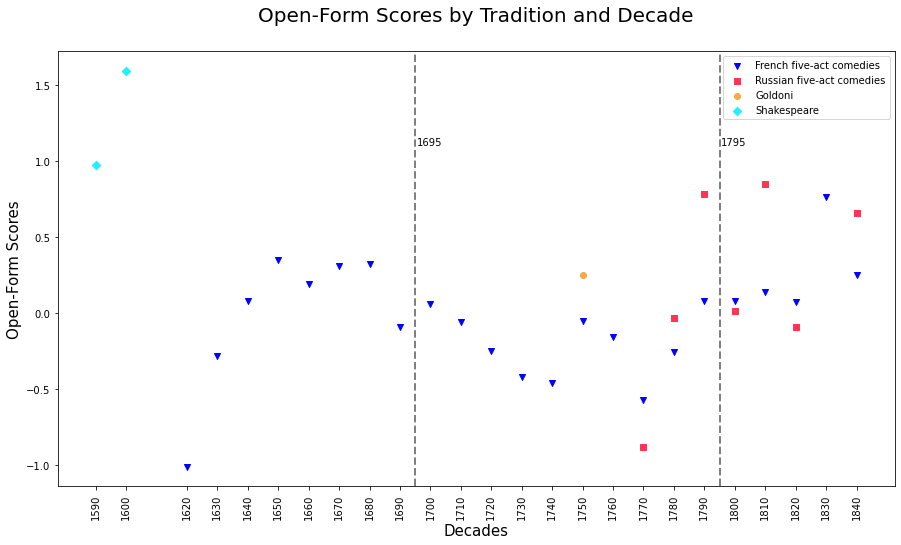

In [98]:
plt.figure(figsize=(15, 8))
plt.title('Open-Form Scores by Tradition and Decade', fontsize=20, pad=30)
plt.scatter(summary_french.index.tolist(), 
            summary_french['open_form_score'], 
            color='blue', 
            marker='v', 
            label='French five-act comedies')

plt.scatter(summary_russian.index.tolist(), 
            summary_russian['open_form_score'], 
            marker='s', 
            color='#FF3355', 
            label='Russian five-act comedies')


plt.scatter(summary_goldoni.index.tolist(), 
            summary_goldoni['open_form_score'], 
            marker="o", 
            color='#F7AA41', 
            label='Goldoni')

plt.scatter(summary_shakespeare.index.tolist(), 
            summary_shakespeare['open_form_score'], 
            marker="D", 
            color='#25EEFF', 
            label='Shakespeare')


plt.xticks(summary_french.index.tolist() + [1590, 1600], rotation=90)
plt.ylabel('Open-Form Scores', fontsize=15)
plt.xlabel('Decades', fontsize=15)
plt.axvline(1695, color='grey',linestyle='dashed', linewidth=2)
plt.axvline(1795, color='grey',linestyle='dashed', linewidth=2)
plt.text(1695.5, 1.1, '1695')
plt.text(1795.5, 1.1, '1795')
plt.legend()
plt.show()

### Summary:
1. Shakespeare's five-act verse comedies were the most experimental in the examined material. Shakespeare's five-act verse comedies of the 1600s were more experimental (open-form score = 1.59) that his comedies of the 1590s (0.97).
2. Goldoni's comedies were more open that French comedies of the 1750s (open-form score for Goldoni = 0.25, French = -0.05).
3. The evolution of the open-form scores of the Russian five-act verse comedy revealed peculiar trends: 
    - In the 1770s, it was less experimental (open-form score = -0.88) than the French comedies of the same decade (open-form score = -0.57). In fact, the score was almost as low as the French comedy of 1620s (Pierre Corneille's *Mélite* with the open-form score = -1.01).
    - In the 1780s, the Russian comedies had a slightly higher open-form score than the contemporaneous French comedies.
    - In the 1790s, the Russian comedies had a much higher open-form score (0.78) than the contemporaneous French comedies (0.08).
    - In the 1800s, the Russian comedies had a very similar open-form score (0.01) to the French (0.08).
    - In the 1810s, the Russian comedies again had a much higher open-form score  (0.85) than the the contemporaneous French comedies (0.14).
    - In the 1820, the Russian comedies were even more closed (-0.09) than the French (0.07).
    - In the 1840s, the Russian comedies were more open (0.66) than the French (0.25).
   

### Conclusions:
1. The evolution curve of the French five-act comedies in verse had a wave-like shape with alternating open and closed forms.
2. The periods of most openness in the French comedy included
    - the Molièrean period (1650 to 1680), which was very far from the openness of Shakespeare;
    - the late Romantic period (1830 - 1840), the first half of which (the 1830s) almost approached the openness of Shakespeare of the 1590s and exceeded the openness the Molièrean period. The second half (the 1840s), did not reach the openness of the Molièrean period and also below the contemporaneous Russian comedies of the time.
    - the 1750s - 1760s revealed an increase in openness. This question requires further investigation.
2. The Russian evolution did not have a wave-shaped curve: since the 1790s, the open and closed forms co-existed (the appearing alternation of the open and closed forms between decades on the graph is simply the result of grouping by decades. In reality, if we were to examine each individual comedy, we would find both closed and open forms co-existing).
3. The French tradition could have been influential for the Russian five-act comedies in verse of the 1770s, 1780s, 1800s, and 1820s. During the 1790s, 1810s, and 1840s, the Russian five-act comedies in verse tended to be more experimental and potentially influenced by another tradition. The high open-form score of the Russian comedies of the 1840s can be attributed to an extremely high mobility coefficient (111) in Petr Grigor’ev's *Zhiteiiskaia shkola* (1849). Based on such features as sigma, the percentage of polylogues, and monologues, this decade was not experimental.
3. Based on the features, describing dramatic characters and their movements, the French tradition (either contemporaneous or preceding) was the most similar tradition to the tentative periods of the Russian comic tradition. This was not the case for the features, describing dramatic characters' speech, where Shakespeare and Goldoni were more similar to the two tentative periods of the Russian five-act comedy in verse.
4. Shakespeare's five-act verse comedies were the most experimental in form out of all five-act verse comedies we analyzed. This is particularly true of the features describing dramatic characters and their movements. Based on the features describing dramatic characters' speech, Shakespeare was not as distant from the continental French-Italian comic tradition.
5. Goldoni's five-act comedies were more experimental than the contemporaneous French five-act comedies in verse. They were close in style to the French comedies of the 1660s and 1840s.